In [1]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
bnc = ccxt.binance()
from matplotlib.pyplot import figure

In [2]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    coinFrames = pd.DataFrame(dataframes[0][["close","volume"]]).rename(columns={'close':"".join(['BTC_',"CLOSE"]),'volume':"".join(['BTC_',"VOL"])})
    for i,coin in enumerate(labels[1:]):
        temp_frame = pd.DataFrame(dataframes[i+1]["close","volume"]).rename(columns={'close':"".join(coin,"CLOSE"),'volume':"".join(coin,"VOL")})
        coinFrames = coinFrames.merge(temp_opens,how='outer',on='timestamp')
    return (coinFrames)

def load_crypto(days=1000,n=30,timeframe='1h'):
    bnc = ccxt.binance()
    #symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    symbols = ['BTC']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60*24):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,pd.to_datetime(since,unit='ms'))
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i+1,:]/price_arr[i,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i+1,:]/price_arr[i,:])
    log_returns_df = pd.DataFrame(log_returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

def proc_ccxt_timestamps(df: object) -> object:
    df.index = pd.to_datetime(df.index,unit='ms')
    return df


In [3]:
#loads and writes the data to csv
#opens=load_crypto(days=1500,timeframe='1d')
#opens.to_csv('BitcoinData')

In [4]:
#loads bitcoin price and volume data and creates appropriate vectors
df = pd.read_csv('BTC_data').set_index("timestamp")
df = proc_ccxt_timestamps(df.dropna(axis=0))

#loads number of bitcoins and processes timestamps
numcoins = pd.read_csv('BTC_numcoins.csv').set_index("Timestamp")
numcoins.index = numcoins.index.rename('timestamp')
numcoins.index = pd.to_datetime(numcoins.index)
numcoins.index = numcoins.index.round('D')

#merges with price data
df = df.merge(numcoins,how='left',on='timestamp')
df = df.fillna(method='bfill')
df['pct_cap'] = df.BTC_VOL/df["total-bitcoins"]

#loads SP500 data
sp = pd.read_csv('SP500_data.csv').set_index("Date")
sp.index = sp.index.rename('timestamp')
sp.index = pd.to_datetime(sp.index)
sp.index = sp.index.round('D')

#merge SP500 on btc table
sp = df.merge(sp,how='left',on='timestamp')
sp.Volume = sp.Volume.fillna(0) #fills empty volumes with 0, not bfill
sp = sp.fillna(method='bfill')
sp = sp.fillna(method='ffill')
sp.Close = pd.to_numeric(sp.Close)
sp.Volume = pd.to_numeric(sp.Volume)
sp["Market_Cap"] = sp.Close*8.6e9
sp["pct"] = sp.Volume/sp.Market_Cap

In [5]:
btc_returns = get_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_logr = get_log_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_lrsq = ((btc_logr)**2)
btc_vol = df.BTC_VOL.iloc[1:].values
btc_pct = df.pct_cap[1:].values
btc_r_pct = np.nan_to_num((btc_returns-1)/btc_pct)
btc_lrsq_pct = np.nan_to_num(btc_lrsq/btc_pct)

sp_returns = get_returns(pd.DataFrame(sp.Close)).Close.values
sp_logr = get_log_returns(pd.DataFrame(sp.Close)).Close.values
sp_lrsq = ((sp_logr)**2)
sp_vol = sp.Volume.iloc[1:].values
sp_pct = sp.pct[1:].values
sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)

/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1722435563.py:14: RuntimeWarning: divide by zero encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1722435563.py:14: RuntimeWarning: invalid value encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1722435563.py:15: RuntimeWarning: divide by zero encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)
/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1722435563.py:15: RuntimeWarning: invalid value encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)


Text(0.5, 1.0, 'Daily Squared Log Returns of Bitcoin and SP500 over time')

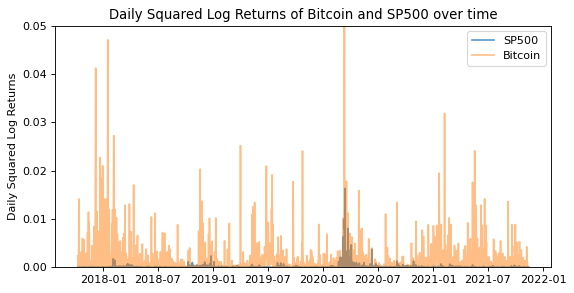

In [32]:
figure(figsize=(8, 4), dpi=80)
plt.plot(sp.index[1:],sp_lrsq,alpha=.75,label="SP500")
plt.plot(sp.index[1:],btc_lrsq,alpha=.5,label="Bitcoin")
plt.ylim((0,.05))
plt.legend()
plt.ylabel("Daily Squared Log Returns")
plt.title("Daily Squared Log Returns of Bitcoin and SP500 over time")

/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1939924681.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.65,label="SP500")
/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/1939924681.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.65,label="SP500")


Text(0.5, 1.0, 'Daily Squared Log Returns / Percent Volume Traded over Time')

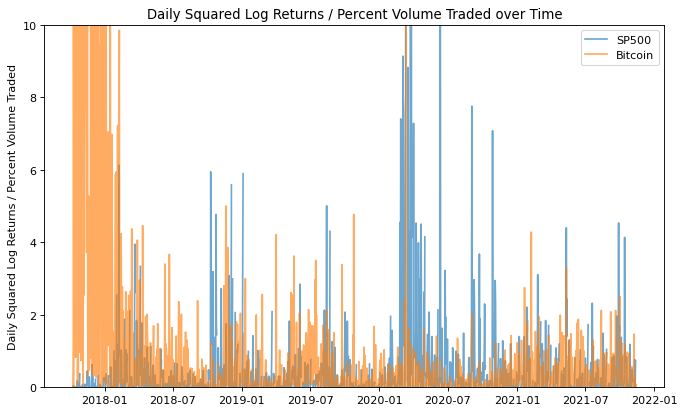

In [41]:
figure(figsize=(10, 6), dpi=80)
plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.65,label="SP500")
plt.plot(sp.index[1:],btc_lrsq/btc_pct,alpha=.65,label="Bitcoin")
plt.legend()
plt.ylim((0,10))
plt.ylabel("Daily Squared Log Returns / Percent Volume Traded")
plt.title("Daily Squared Log Returns / Percent Volume Traded over Time")

Text(0.5, 1.0, '^GSPC (SP500) Value vs Time')

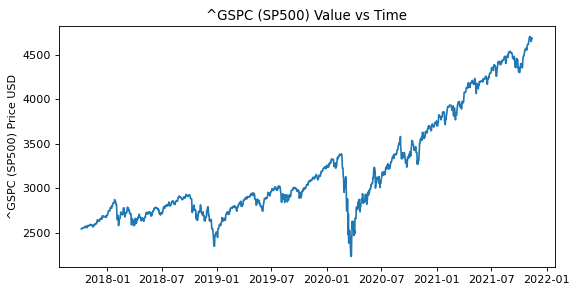

In [7]:
figure(figsize=(8, 4), dpi=80)
plt.plot(pd.DataFrame(sp.Close))
plt.ylabel("^GSPC (SP500) Price USD")
plt.title("^GSPC (SP500) Value vs Time")

In [8]:
opens = pd.read_csv('CryptoPrices').set_index("timestamp")
opens = opens.dropna(axis=0)
opens.head()

,BTC,ETH,BNB,SOL,ADA,XRP,DOT,DOGE,SHIB,LUNA,...,ALGO,BCH,VET,AXS,XLM,ATOM,ICP,FIL,THETA,TRX
timestamp,,,,,,,,,,,,,,,,,,,,,
1620694800000,55453.39,3856.28,628.94,41.803,1.6280,1.3960,36.156,0.45161,0.000033,15.506,...,1.3480,1314.55,0.19963,7.0618,0.64587,24.860,249.28,135.51,10.190,0.12496
1620698400000,55565.33,3901.50,639.30,42.303,1.6385,1.4096,36.717,0.46201,0.000034,15.874,...,1.3712,1361.66,0.20210,7.2914,0.65150,25.010,384.84,136.93,10.405,0.12661
1620702000000,54600.00,3819.60,630.72,40.844,1.6077,1.3807,36.157,0.45225,0.000037,15.561,...,1.3403,1317.41,0.19725,7.1092,0.62685,24.186,436.92,135.26,10.143,0.12286
1620705600000,55142.44,3855.53,633.10,40.400,1.6198,1.3828,36.003,0.47083,0.000035,15.769,...,1.3513,1325.08,0.19988,7.0690,0.63293,24.499,574.31,137.26,10.293,0.12324
1620709200000,55337.03,3907.36,643.41,40.748,1.6251,1.4140,36.480,0.48454,0.000035,16.020,...,1.3802,1344.92,0.20428,7.2992,0.64298,25.086,435.04,137.52,10.519,0.12620


Text(0.5, 1.0, 'Bitcoin Price vs Time')

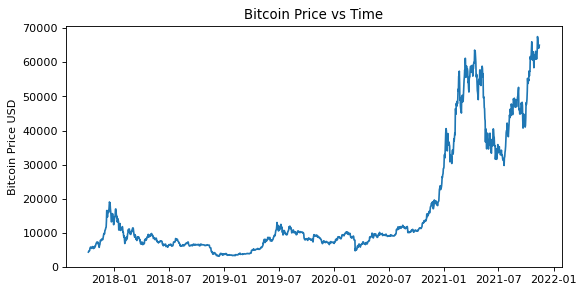

In [9]:
figure(figsize=(8, 4), dpi=80)
plt.plot(pd.DataFrame(df.BTC_CLOSE))
plt.ylabel("Bitcoin Price USD")
plt.title("Bitcoin Price vs Time")

1500

1


/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/3389712626.py:1: RuntimeWarning: divide by zero encountered in true_divide
  sp_x = sp_lrsq/sp_pct
/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_30598/3389712626.py:1: RuntimeWarning: invalid value encountered in true_divide
  sp_x = sp_lrsq/sp_pct


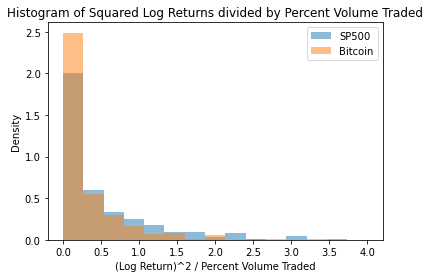

In [59]:
sp_x = sp_lrsq/sp_pct
btc_x = btc_lrsq/btc_pct
sp_x[np.isnan(sp_x)] = 0
sp_x[np.isinf(sp_x)] = 0
sp_x = sp_x[-500:]
btc_x = btc_x[-500:]
plt.hist(sp_x,bins=15,alpha=.5,range=(0.000001,4),density=True,label="SP500")
plt.hist(btc_x,bins=15,alpha=.5,range=(0.000001,4),density=True,label="Bitcoin")
plt.xlabel("(Log Return)^2 / Percent Volume Traded")
plt.ylabel("Density")
plt.title("Histogram of Squared Log Returns divided by Percent Volume Traded")
plt.legend()
print('1')

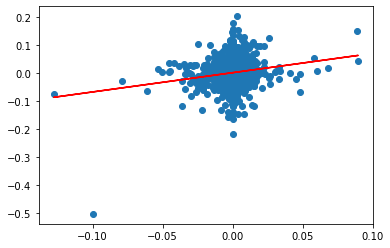

In [11]:
plt.scatter(sp_logr,btc_logr)
m,b = np.polyfit(sp_logr, btc_logr, 1)
plt.plot(sp_logr,m*sp_logr+b,'r')

Text(0.5, 1.0, 'Daily Squared Log Returns / Percent Volume Traded over Time (21 day moving average)')

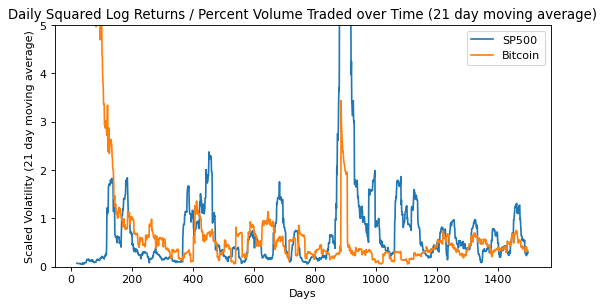

In [44]:
figure(figsize=(8, 4), dpi=80)
plt.plot(pd.DataFrame(sp_lrsq).rolling(21).mean()/pd.DataFrame(sp_pct).rolling(21).mean(),label="SP500")
plt.plot(pd.DataFrame(btc_lrsq).rolling(21).mean()/pd.DataFrame(btc_pct).rolling(21).mean(),label="Bitcoin")
plt.legend()
plt.ylim((0,5))
plt.ylabel("Scaled Volatility (21 day moving average)")
plt.xlabel("Days")
plt.title("Daily Squared Log Returns / Percent Volume Traded over Time (21 day moving average)")

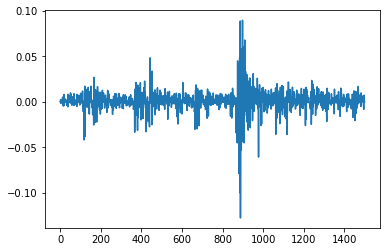

In [13]:
plt.plot(sp_logr)